In [343]:
import torch 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

import torchvision 
import torch.nn.functional as F 

from torch import nn , optim
from torchvision import datasets , transforms , models 
from torch.utils import data 

from collections import OrderedDict
from PIL import Image 

import time 
import pickle 

import tqdm

from torch.utils.data import DataLoader 

In [344]:
class Outconv(nn.Module):
    def __init__(self , input_ch , output_ch):
        super(Outconv , self).__init__()
        self.conv = nn.ConvTranspose2d(input_ch , output_ch , kernel_size = 4 , stride = 2 , padding = 1)
        
    def forward(self , x):
        x = torch.sigmoid(self.conv(x))
        
        return x 

In [345]:
class Downsample(nn.Module):
    def __init__(self , input_ch , output_ch , batch_norm = True):
        super(Downsample , self).__init__()
        self.conv = nn.Conv2d( input_ch , output_ch , kernel_size = 4 , padding = 1 , stride = 2) 
        self.norm = nn.BatchNorm2d(output_ch)
        self.leaky_relu = nn.LeakyReLU(negative_slope = 0.2)
        self.batch_norm = batch_norm
        
    def forward(self , x):
        if self.batch_norm:
            x = self.leaky_relu(self.norm(self.conv(x)))
            
        else :
            x = self.leaky_relu(self.conv(x))
            
        return x 

In [346]:
class Upsample(nn.Module):
    def __init__(self , input_ch , output_ch , dropout = False):
        super(Upsample , self).__init__()
        self.deconv = nn.ConvTranspose2d(input_ch , output_ch , kernel_size = 4 , stride = 2 , padding = 1)
        self.norm = nn.BatchNorm2d(output_ch)
        self.leaky_relu = nn.LeakyReLU(negative_slope = 0.2)
        self.drop = dropout
        self.dropout = nn.Dropout2d(0.3)
        
    def forward(self , x):
        if self.drop :
            x = self.leaky_relu(self.dropout(self.norm(self.deconv(x))))
            
        else :
            x = self.leaky_relu(self.norm(self.deconv(x)))
            
        return x

In [347]:
class Unet(nn.Module):
    def __init__(self , in_channels , out_channels):
        super(Unet , self).__init__()
        
        # Input 256 * 256
        
        self.in_conv = Downsample(in_channels , 32 , batch_norm = False)  # 32 * 128 * 128
        self.down1 = Downsample(32 , 64)  # 64 * 64 * 64
        self.down2 = Downsample(64 , 128) # 128 * 32 * 32 
        self.down3 = Downsample(128 , 256) # 256 * 16 * 16
        self.down4 = Downsample(256 , 512) # 512 * 8 * 8
        self.down5 = Downsample(512 , 512) # 512 * 4 * 4
        self.down6 = Downsample(512 , 512) # 512 * 2 * 2 
        self.down7 = Downsample(512 , 512) # 512 * 1 * 1
        
        self.up_1 = Upsample(512 , 512 , dropout = True) # 512 * 2 * 2
        self.up_2 = Upsample(1024 , 512 , dropout = True) # 512 * 4 * 4 
        self.up1 = Upsample(1024 , 512 , dropout = True) # 512 * 8 * 8
        self.up2 = Upsample(1024 , 256 , dropout = True) # 256 * 16 * 16
        self.up3 = Upsample(512 , 128)  # 128 * 32 * 32 
        self.up4 = Upsample(256 , 64)  # 64 * 64 * 64
        self.up5 = Upsample(128 , 32)  # 32 * 128 * 128
        self.out_conv = Outconv(64 , out_channels) # out_channels * 256 * 256
        
        self.down_stack = [self.in_conv , self.down1 , self.down2 , 
                           self.down3 , self.down4 , self.down5 , 
                           self.down6 , self.down7]
        
        self.up_stack = [self.up_1 , self.up_2 , self.up1 ,
                         self.up2 ,self.up3 , self.up4 ,
                         self.up5]
        
        
    def forward(self , x):
        skips = []
        
        for down in self.down_stack:
            x = down(x)
            #print(x.shape)
            skips.append(x)
            
        skips = list(reversed(skips[:-1]))
        
        for up , skip in zip(self.up_stack , skips):
            x = up(x)
           # print(x.shape , skip.shape)
            x = torch.cat([x, skip], dim=1)
            
        x = self.out_conv(x)
        
        return x 

In [348]:
model = Unet(1,1)

In [349]:
device  = "cuda"

model.to(device)

Unet(
  (in_conv): Downsample(
    (conv): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (down1): Downsample(
    (conv): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (down2): Downsample(
    (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (down3): Downsample(
    (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (down4

In [350]:
import glob

img_noisy_names = []

for i in glob.glob("train/*.png"):
    img_noisy_names.append(i)
    
print(len(img_noisy_names))

144


In [351]:
img_names = []

for i in glob.glob("train_cleaned/*.png"):
    img_names.append(i)
    
print(len(img_names))

144


In [352]:
from sklearn.model_selection import train_test_split 

Xtrain , Xtest , Ytrain , Ytest  = train_test_split(img_noisy_names , img_names , test_size = 0.2 , random_state = 2)

In [353]:
print(len(Xtrain))
print(len(Xtest))
print(len(Ytrain))
print(len(Ytest))

115
29
115
29


In [354]:
class Dataset(data.Dataset):
    def __init__(self, img_noisy_names , img_names , transform=None):
        self.noisy = img_noisy_names
        self.img = img_names
        self.transform = transform

    def __len__(self):
        return len(self.noisy)

    def __getitem__(self, index):
        X = Image.open(self.noisy[index])
        Y = Image.open(self.img[index])
        
        if self.transform:
            X = self.transform(X)
            Y = self.transform(Y)

        return X , Y

In [355]:
data_transforms = {
    
    'train' : transforms.Compose([transforms.Resize((256,256)),
                                 transforms.ToTensor(),
                                 ]),
    
    'test' : transforms.Compose([transforms.Resize((256,256)),
                                 transforms.ToTensor(),
                                ])
}

In [356]:
training_data = Dataset( Xtrain , Ytrain , transform = data_transforms['train'])
testing_data = Dataset( Xtest , Ytest  ,transform = data_transforms['test'])

In [357]:
data_loader = {
    
    'train' : DataLoader(training_data, batch_size = 8 , shuffle = True) , 
    
    'test' : DataLoader( testing_data , batch_size = 8 , shuffle = False)
    
}

(8, 1, 256, 256)
(8, 256, 256, 1)
(256, 256, 1)


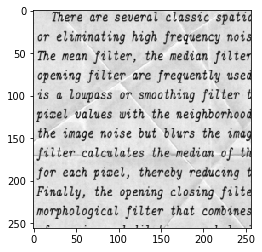

In [358]:
images , labels = next(iter(data_loader['train']))

images = images.numpy()

print(images.shape)

images = images.transpose(0,2,3,1)

print(images.shape)

img = images[0]

print(img.shape)

img = img.clip(0,1)

plt.imshow(img.reshape(256,256) , cmap = "gray")

In [359]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [360]:
n_epochs = 50
    
best_test_loss = np.Inf

for epoch in range(1, n_epochs+1):
    
    train_loss = 0.0
    test_loss = 0.0
    
    model.train()
    for data in data_loader['train']:

        noisy_imgs, images = data
        
        images = images.cuda()
        noisy_imgs = noisy_imgs.cuda()

        optimizer.zero_grad()

        outputs = model(noisy_imgs)

        loss = criterion(outputs, images)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()*images.size(0)
        
    with torch.no_grad():
        
        model.eval()
        
        for data in data_loader['test']:
            noisy_imgs, images = data
        
            images = images.cuda()
            noisy_imgs = noisy_imgs.cuda()

            outputs = model(noisy_imgs)

            loss = criterion(outputs, images)

            test_loss += loss.item()*images.size(0)
        
    test_loss = test_loss/len(data_loader['test'])
    train_loss = train_loss/len(data_loader['train'])
    
    if test_loss < best_test_loss :
        print(" Saving model with test loss {:.4f} < {:.4f}".format(test_loss , best_test_loss))
        best_test_loss = test_loss
        torch.save(model.state_dict() , "CustomUnetweights.pth")
    
    print('Epoch: {} \tTraining Loss: {:.4f} \t Testing Loss : {:.4f}'.format( epoch, train_loss , test_loss))

 Saving model with test loss 0.5884 < inf
Epoch: 1 	Training Loss: 0.8960 	 Testing Loss : 0.5884
 Saving model with test loss 0.2243 < 0.5884
Epoch: 2 	Training Loss: 0.2572 	 Testing Loss : 0.2243
 Saving model with test loss 0.1955 < 0.2243
Epoch: 3 	Training Loss: 0.1523 	 Testing Loss : 0.1955
 Saving model with test loss 0.1317 < 0.1955
Epoch: 4 	Training Loss: 0.1356 	 Testing Loss : 0.1317
 Saving model with test loss 0.1151 < 0.1317
Epoch: 5 	Training Loss: 0.1175 	 Testing Loss : 0.1151
Epoch: 6 	Training Loss: 0.0996 	 Testing Loss : 0.1976
Epoch: 7 	Training Loss: 0.0829 	 Testing Loss : 0.1636
 Saving model with test loss 0.0933 < 0.1151
Epoch: 8 	Training Loss: 0.0682 	 Testing Loss : 0.0933
 Saving model with test loss 0.0566 < 0.0933
Epoch: 9 	Training Loss: 0.0551 	 Testing Loss : 0.0566
 Saving model with test loss 0.0459 < 0.0566
Epoch: 10 	Training Loss: 0.0457 	 Testing Loss : 0.0459
Epoch: 11 	Training Loss: 0.0385 	 Testing Loss : 0.0509
 Saving model with test l

In [361]:
model.to("cpu")

model.load_state_dict(torch.load("CustomUnetweights.pth"))

from PIL import Image

def load_image(img_path):
    
    image = Image.open(img_path)
        
    in_transform = transforms.Compose([transforms.Resize((256,256)),
                                       transforms.ToTensor(),])
    
    image = in_transform(image)[:1,:,:].unsqueeze(0)
    
    return image

torch.Size([1, 1, 256, 256])
(256, 256, 1)


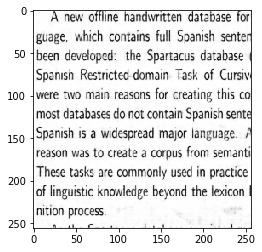

In [362]:
image = load_image("test/118.png")

with torch.no_grad():
    model.eval()
    output = model(image)
    print(output.shape)
    
output = output.numpy()
    
output = output.transpose(0,2,3,1)

img = output[0]

print(img.shape)

img = img.clip(0,1)

plt.imshow(img.reshape(256,256) , cmap = "gray")